<a href="https://colab.research.google.com/github/GoogleCloudPlatform/tf-estimator-tutorials/blob/master/00_Miscellaneous/text-similarity-analysis/bqml/classification_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from google.cloud import bigquery
client = bigquery.Client(project='yaboo-text-similarity-analysis')

## Table Schema

In [26]:
dataset_id = 'my_dataset'
table_id = 'my_table'

dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)
table = client.get_table(table_ref)

# View table properties
for e in table.schema:
  print(e)

SchemaField('topics', 'STRING', 'NULLABLE', None, ())
SchemaField('title', 'STRING', 'NULLABLE', None, ())
SchemaField('content', 'STRING', 'NULLABLE', None, ())
SchemaField('title_embed', 'FLOAT', 'REPEATED', None, ())
SchemaField('content_embed', 'FLOAT', 'REPEATED', None, ())


##Create Features

In [0]:
def get_flattened_embeddings(input_column='content_embed', n=512):
  L = []
  for i in range(n):
    L.append("{0}[OFFSET({1})] AS {0}_{1}".format(input_column, i))
  return (',').join(L)

def get_one_hot_vectors(input_column='topics', categories=['acl','gas']):
  L = []
  for cat in categories:
    L.append(
      "CASE WHEN '{1}' in UNNEST(SPLIT({0})) THEN 1 ELSE 0 END as {1}".format(
        input_column, cat))
  return (',').join(L)

In [0]:
def get_topics_and_count():
  sql = """
  WITH topics_flatten AS
  (
  SELECT topic FROM
    (
    SELECT 
      SPLIT(topics, ',') AS topic
    FROM
      `my_dataset.my_table`
    WHERE
      topics != ''
    ),
    unnest(topic) topic
  )

  SELECT 
    REPLACE(topic, '-', '_') AS topic,
    count(*) AS count
  FROM
    topics_flatten
  GROUP BY
    topic
  """
  return sql

df = client.query(get_topics_and_count()).to_dataframe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e601660b8>]],
      dtype=object)

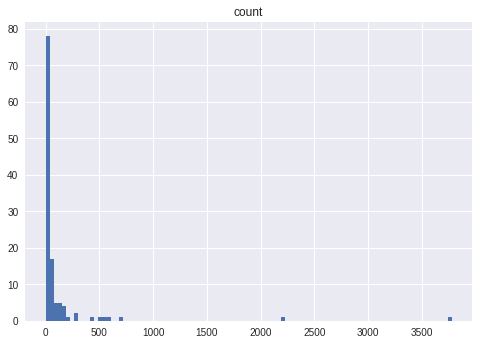

In [33]:
df.hist(bins=100)

In [37]:
target_categories = list(df[df['count'] >= 100].topic)
target_categories[:2]

['acq', 'bop']

In [35]:
def create_dataset(categories=['acq'], embed='content_embed', n=512):
  sql = """
  CREATE OR REPLACE TABLE `my_dataset.input_data`
    AS
    (
      SELECT
        STRUCT( {0} ) AS label,
        STRUCT( {1} ) AS feature
      FROM
        `my_dataset.my_table`
    )
  """.format(
      get_one_hot_vectors(input_column='topics', categories=categories),
      get_flattened_embeddings(input_column=embed, n=n))
  return sql

sql = create_dataset(
  categories=target_categories, embed='content_embed', n = 512)
client.query(sql)

## Create Models

In [38]:
def create_model(target='acq'):
  sql = """
  CREATE OR REPLACE MODEL `my_dataset.model_{0}`
  OPTIONS (
      model_type='logistic_reg',
      input_label_cols=['label']) AS
  SELECT
      label.{0} as label,
      feature.*
  FROM
      `my_dataset.input_data`
  """.format(target)

  return sql

sql = create_model(target='acq')
client.query(sql)

## Evaluate Models

In [39]:
def evaluate_model(target='acq', threshold=0.55):
  sql = """
  SELECT
    *
  FROM
    ML.EVALUATE(MODEL `my_dataset.model_{0}`,
      (
      SELECT
        label.{0} as label,
        feature.*
      FROM
        `my_dataset.input_data`),
      STRUCT({1} AS threshold))
  """.format(target, threshold)
  return sql
    
sql = evaluate_model(target='acq', threshold=0.55)
client.query(sql).to_dataframe()

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.734908,0.38009,0.912146,0.501044,0.310353,0.901


In [0]:
def evaluate_model_roc(target='acq'):
  sql = """
  SELECT
    *
  FROM
    ML.ROC_CURVE
    (
      MODEL `my_dataset.model_{0}`,
      (
        SELECT
          label.{0} as label,
          feature.*
        FROM
          `my_dataset.input_data`
      )
    )
  """.format(target)
  return sql

sql = evaluate_model_roc(target='acq')
df = client.query(sql).to_dataframe()

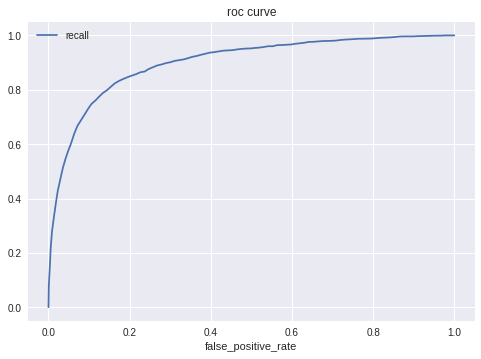

In [41]:
df.plot(x='false_positive_rate', y='recall', grid=True, title='roc curve')

In [0]:
def evaluate_model_pr(target='acq'):
  sql = """
  SELECT
    recall,
    true_positives / (true_positives + false_positives) AS precision
  FROM
    ML.ROC_CURVE(
      MODEL `my_dataset.model_{0}`,
      (SELECT label.{0} as label, feature.* FROM `my_dataset.input_data`))
  """.format(target)
  return sql

sql = evaluate_model_pr(target='acq')
df = client.query(sql).to_dataframe()

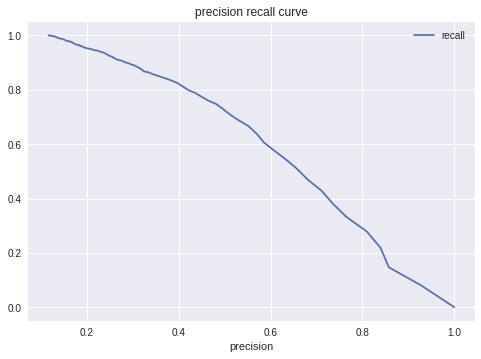

In [43]:
df.plot(x='precision', y='recall', grid=True, title='precision recall curve')

In [44]:
def evaluate_model_confusion_matrix(target='acq'):
    sql = """
    SELECT
      *
    FROM
      ML.CONFUSION_MATRIX(MODEL `my_dataset.model_{0}`,
      (
        SELECT
          label.{0} as label,
          feature.*
        FROM
          `my_dataset.input_data`))
    """.format(target)
    return sql

sql = evaluate_model_confusion_matrix(target='acq')
client.query(sql).to_dataframe()

,expected_label,_0,_1
0,0,16333,500
1,1,1157,1053


## Multi-Class Logistic Regression

In [45]:
for target_category in target_categories[:3]:
  print("Creating a model for {0}...".format(target_category))
  client.query(create_model(target=target_category))

Creating a model for acq...
Creating a model for bop...
Creating a model for cpi...


In [46]:
d_cat_to_eval = {}

for target_category in target_categories[:3]:
  print("Evaluating a model for {0}...".format(target_category))
  sql = evaluate_model(target=target_category, threshold=0.55)
  d_cat_to_eval[target_category] = client.query(sql).to_dataframe()

Evaluating a model for acq...
Evaluating a model for bop...
Evaluating a model for cpi...


In [47]:
d_cat_to_eval['acq']

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.305033,0.770588,0.769627,0.437059,0.629115,0.850683


In [48]:
d_cat_to_eval['bop']

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,NaN,0.0,0.994696,0.0,0.152062,0.883531


In [49]:
d_cat_to_eval['cpi']

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,NaN,0.0,0.994696,0.0,0.151838,0.894839
